In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

## Load Conformal Analysis Data:

In [2]:
# Load results form .pkl file
output_dir = '../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results'

filename = os.path.join(output_dir, 'results.pkl')
with open(filename, 'rb') as f:
    loaded_results = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results/results.pkl


In [3]:
# Loaded Coformal Analysis Data:
# float value
alpha_risk = loaded_results["alpha_risk"]

# float value:
alpha_high_risk = loaded_results["alpha_high_risk"]

# dict: prefix length, dict: case name, (List of fitness scores, mean fitness scores, std fitness scores)
case_name_fitness_scores_per_prefix_length = loaded_results["case_name_fitness_scores_per_prefix_length"]

# dict: prefix length, (mean target fitness score, mean most likely fitness score, mean means samples fitness scores)
mean_tgts_ml_samples_per_prefix_length = loaded_results["mean_tgts_ml_samples_per_prefix_length"]

# dict: prefix length, (mean of std within fitness scores, std of mean sampled fitness scores)
std_samples_per_prefix_length = loaded_results["std_samples_per_prefix_length"]

# Risk:
# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
q_samples_per_prefix_length = loaded_results["q_samples_per_prefix_length"]

# High-Risk:
# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
r_samples_per_prefix_length = loaded_results["r_samples_per_prefix_length"]

## Visualize Conformal Analysis Thresholds and Means and Stds (Uncertainties) Per Prefix Lengths:

q threshold with 1-alpha coverage:  [0.88909881 0.93617976 0.96264563 0.8182074  0.83927125 0.73936692
 0.76448889 0.6062421  0.62587879]
r threshold with 1-alpha coverage:  [0.83698882 0.88317053 0.79140754 0.81392976 0.71465545 0.72188092
 0.65441111 0.6062421  0.62587879]


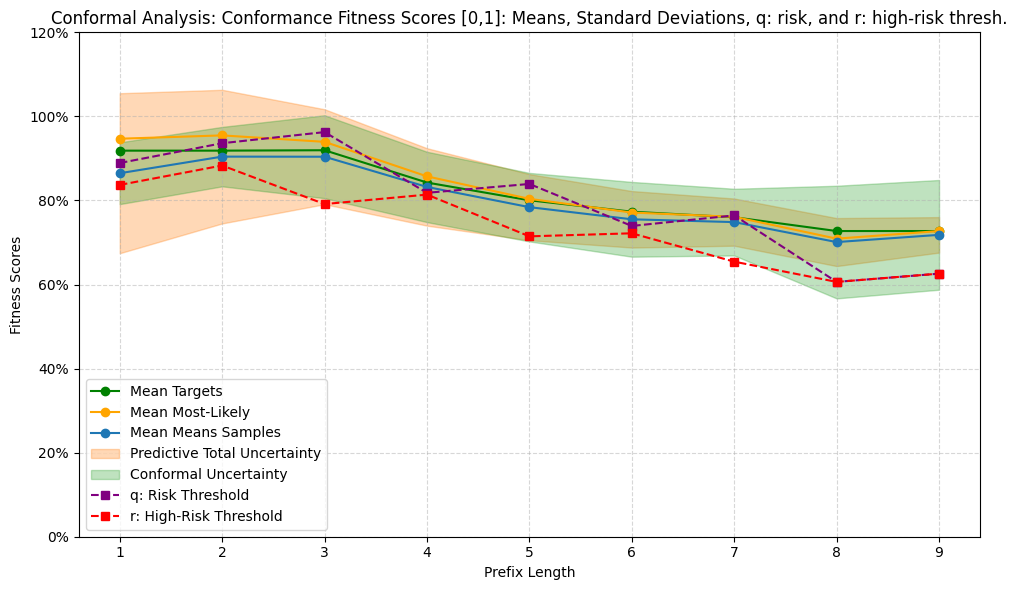

In [4]:
"""
Visualization of conformal-conformance-analysis:
- Lines of mean fitness values (targte, most-likely, mean of samples) per prefix length as threshold.

- Line for Risk Threshold: Ensures that all "safe" test cases above cover >= 1-alpha_risk coverage.
- Line for High-Risk Threshold: Ensures that all "safe" test cases above cover >= 1-alpha_high_risk coverage.

- Uncertainty of Probabilistic Suffix Prediction: Mean of ± 1.645 σ of fitness scores of sample suffixes from a case with the same prefix length.
- Uncertainty of Conformal Predictio: ± σ of all mean fitness score of sample suffixes from a case with the same prefix length.
"""

prefix_lengths = []

means_tgts = []
means_mls = []
means_sms = []

mean_within_std_sm = []
std_between_means_sm = []
total_stds = []

# Risk Threshold:
q_samples = []

# High Risk Threshoold
r_samples = []

# iterate over sorted prefix lengths
for prefix_len in sorted(mean_tgts_ml_samples_per_prefix_length.keys()):
    prefix_lengths.append(prefix_len)

    # extract the three “means” for this prefix
    mean_tgt, mean_ml, mean_samples = mean_tgts_ml_samples_per_prefix_length[prefix_len]
    means_tgts.append(mean_tgt)
    means_mls.append(mean_ml)
    means_sms.append(mean_samples)

    # extract the two std‐values for this prefix
    within_std, between_std = std_samples_per_prefix_length[prefix_len]
    mean_within_std_sm.append(within_std)
    std_between_means_sm.append(between_std)
    
    total_stds.append(within_std + between_std) 

    # extract the conformal q‐threshold for samples
    q_samples.append(q_samples_per_prefix_length[prefix_len])
    
    # extract the conformal q‐threshold for samples
    r_samples.append(r_samples_per_prefix_length[prefix_len])
      
# Sort by prefix (normally already sorted) length and transform to numpy array.
idx = np.argsort(prefix_lengths)

prefix_lengths = np.array(prefix_lengths)[idx]

means_tgts = np.array(means_tgts)[idx]
# print("Means Target: ", means_tgts)
means_mls = np.array(means_mls)[idx]
# print("Means Most-likely: ", means_mls)
means_sms = np.array(means_sms)[idx]
# print("Means Means samples: ", means_sms)

std_probabilistic_suffix_pred = np.array(mean_within_std_sm)[idx]
# print("Total Predictive Uncertainty: ", std_probabilistic_suffix_pred)
std_conformal = np.array(std_between_means_sm)[idx]
# print("Conformal Uncertainty: ", std_conformal)

# Get two-side 1-alpha/2-intervall by using alpha/2:
z90 = 1.645  

# Build Bounds based on stds
# Std within (fitness scores of T MC-Samples)-band: Probabilistic Suffix Prediction Fitness Score standard deviation:
lower_psp = means_sms - z90 * std_probabilistic_suffix_pred
upper_psp = means_sms + z90 * std_probabilistic_suffix_pred

# Std between-band: Conformal Calibration
lower_conformal = means_sms - std_conformal
upper_conformal = means_sms + std_conformal

# Risk thresholds
q_samples = np.array(q_samples)[idx]
print("q threshold with 1-alpha coverage: ", q_samples)

# High-Risk thresholds
r_samples = np.array(r_samples)[idx]
print("r threshold with 1-alpha coverage: ", r_samples)

# Plot
plt.figure(figsize=(10, 6))

# Means:
plt.plot(prefix_lengths, means_tgts, marker='o', label='Mean Targets', color='green')
plt.plot(prefix_lengths, means_mls, marker='o', label='Mean Most-Likely', color='orange')
plt.plot(prefix_lengths, means_sms, marker='o', label='Mean Means Samples', color='C0')

# Uncertainty (PSP) ± σ:
plt.fill_between(prefix_lengths,
                 lower_psp, 
                 upper_psp,
                 alpha=0.3, color='C1', label='Predictive Total Uncertainty')

# Uncertianty (Conformal Analysis) ± σ
plt.fill_between(prefix_lengths,
                 lower_conformal, 
                 upper_conformal,
                 alpha=0.3, color='C2', label='Conformal Uncertainty')

# High-Risk threshold
plt.plot(prefix_lengths, q_samples, marker='s', linestyle='--', color='purple', label='q: Risk Threshold')

# Risk threshold
plt.plot(prefix_lengths, r_samples, marker='s', linestyle='--', color='red', label='r: High-Risk Threshold')

# 6. Polish
plt.xlabel('Prefix Length')
plt.ylabel('Fitness Scores')
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(prefix_lengths)  # <--- ensures discrete x-axis ticks
plt.title('Conformal Analysis: Conformance Fitness Scores [0,1]: Means, Standard Deviations, q: risk, and r: high-risk thresh.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


## Uncertainty: Total, Aleatoric, and Epistemic:

In [5]:
# Load results form .pkl file
output_dir = '../../../../../../data/Helpdesk/conformal_val_without_dropout/conformal_conformance_results'

filename = os.path.join(output_dir, 'results.pkl')
with open(filename, 'rb') as f:
    loaded_results_no_dropout = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_val_without_dropout/conformal_conformance_results/results.pkl


In [6]:
# Data loaded:
std_samples_per_prefix_length_no_dropout = loaded_results_no_dropout["std_samples_per_prefix_length"]

In [7]:
# Caluclate the total, aleatoric, and epistemic predictive (uncertainty) standard deviations:
from conformal_analysis.fitness_score_uncertainty import FitnessUncertainty

prefix_lengths = []
within_std_prefix_length = []
within_std_prefix_length_no_dropout = [] 

# iterate over sorted prefix lengths
for prefix_len in sorted(std_samples_per_prefix_length.keys()):
    prefix_lengths.append(prefix_len)

    # extract the two std‐values for this prefix
    within_std, _ = std_samples_per_prefix_length[prefix_len]
    within_std_prefix_length.append(within_std)
    
    within_std_no_dropout, _ = std_samples_per_prefix_length_no_dropout[prefix_len]
    within_std_prefix_length_no_dropout.append(within_std_no_dropout)
    
# Sort by prefix (normally already sorted) length and transform to numpy array.
idx = np.argsort(prefix_lengths)
prefix_lengths = np.array(prefix_lengths)[idx]

pred_sd_prefix_length = np.array(within_std_prefix_length)[idx]
pred_sd_prefix_length_no_dropout = np.array(within_std_prefix_length_no_dropout)[idx]

fit_sd = FitnessUncertainty(dropout_fitness_std=pred_sd_prefix_length, no_dropout_fitness_std=pred_sd_prefix_length_no_dropout)

total_sds = fit_sd.total_fitness_score_sd()
print("Total Predictive SDs: ", total_sds)

aleatoric_sds = fit_sd.aleatoric_fitness_score_sd()
print("Aleatoric Predictiive SDs: ", aleatoric_sds)

epistemic_sds = fit_sd.epistemic_fitness_score()
print("Epistemic Predictie SDs: ", epistemic_sds)

Total Predictive SDs:  [0.11569082 0.09664914 0.0686621  0.05599304 0.04778418 0.04085175
 0.03411594 0.03469154 0.02565249]
Aleatoric Predictiive SDs:  [0.11449186 0.09434424 0.06668083 0.05352275 0.04491056 0.03782212
 0.03194931 0.03174068 0.02425791]
Epistemic Predictie SDs:  [0.0011989590274601308, 0.0023049044051504236, 0.001981268117455817, 0.002470288911074564, 0.002873623197518445, 0.003029633311609707, 0.002166631865059908, 0.0029508635774908726, 0.0013945755347047895]


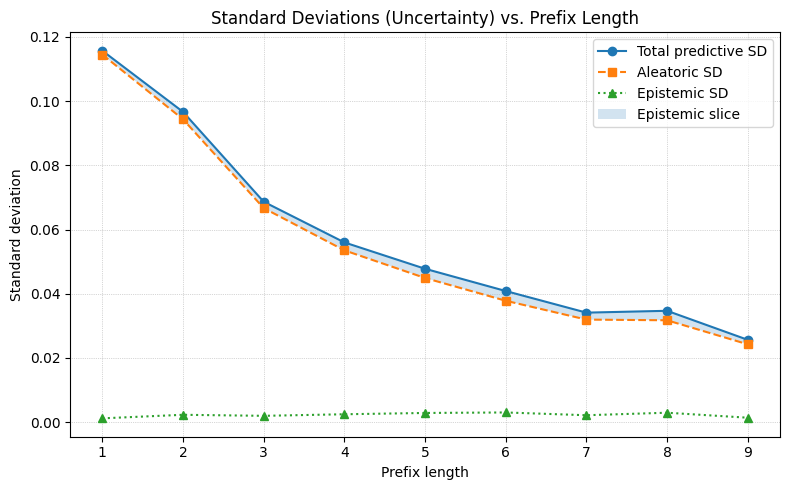

In [8]:
"""
Plots total, aleatoric, and epistemic predictive SDs over prefix lengths,
with a shaded band between aleatoric and total to highlight the epistemic part.

Args:
prefix_lengths (list of int): 1-based prefix lengths.
total_sds        (list of float): Total predictive standard deviations.
aleatoric_sds    (list of float): Aleatoric predictive standard deviations.
epistemic_sds    (list of float): Epistemic predictive standard deviations.
"""

title=("Standard Deviations (Uncertainty) vs. Prefix Length")
    
fig, ax = plt.subplots(figsize=(8, 5))

# Plot each series
ax.plot(prefix_lengths, total_sds,
        marker='o', linestyle='-', label='Total predictive SD')
ax.plot(prefix_lengths, aleatoric_sds,
        marker='s', linestyle='--', label='Aleatoric SD')
ax.plot(prefix_lengths, epistemic_sds,
        marker='^', linestyle=':', label='Epistemic SD')

# Shade between aleatoric and total to show epistemic contribution
ax.fill_between(prefix_lengths,
                aleatoric_sds,
                total_sds,
                alpha=0.2,
                label='Epistemic slice')

# Labels and legend
ax.set_xlabel("Prefix length")
ax.set_ylabel("Standard deviation")
ax.set_title(title)
ax.set_xticks(prefix_lengths)
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', linewidth=0.5)

plt.tight_layout()

plt.show()
